# Auto code formatter

In [ ]:
%load_ext lab_black

# import

In [1]:
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torchvision.transforms as transforms

manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# inputs

In [2]:
dataroot = glob("/home/b20saito/WORK/DATASETS/anime-face-dataset/data/*.png")
print(len(dataroot))
workers = 2
batch_size = 64
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 10
lr = 0.0002
beta1 = 0.5
ngpu = 1

19314


# data

In [3]:
class MyDataset(Dataset):
    def __init__(self, path, transforms=None):
        super(MyDataset, self).__init__()
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        img = Image.open(self.path[idx]).convert("RGB")

        if self.transforms is not None:
            transformed_data = self.transforms(img)
        return transformed_data

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
datasets = MyDataset(dataroot, transforms=transform)

dataloader = DataLoader(datasets, batch_size=batch_size, shuffle=True)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

tensor([[[[ 0.9922,  0.9216,  0.2863,  ...,  0.1137,  0.1216,  0.1059],
          [ 1.0000,  0.6157,  0.1608,  ...,  0.0902,  0.1059,  0.1059],
          [ 1.0000,  0.1059, -0.0196,  ...,  0.0745,  0.1137,  0.1059],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ..., -0.5137, -0.4275, -0.1922],
          [ 1.0000,  1.0000,  1.0000,  ..., -0.5765, -0.5294, -0.4588],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.0275, -0.5216, -0.4431]],

         [[ 0.9922,  0.9294,  0.3098,  ...,  0.1373,  0.1451,  0.1294],
          [ 1.0000,  0.6157,  0.1765,  ...,  0.1137,  0.1294,  0.1294],
          [ 1.0000,  0.1137,  0.0039,  ...,  0.0980,  0.1373,  0.1294],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ..., -0.4588, -0.3647, -0.1529],
          [ 1.0000,  1.0000,  1.0000,  ..., -0.5451, -0.4667, -0.4039],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.0510, -0.5451, -0.3882]],

         [[ 0.9843,  0.9373,  0.3412,  ...,  0.2078,  0.2157,  0.1843],
          [ 1.0000,  0.6392,  

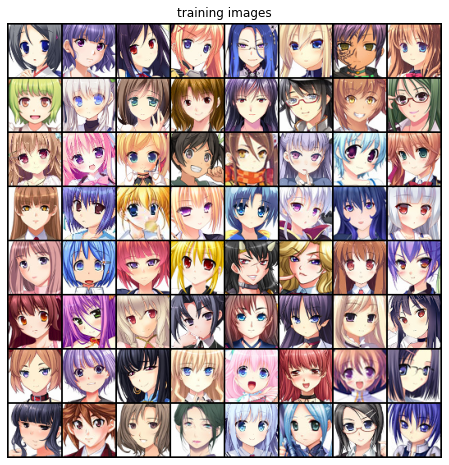

In [5]:
real_batch = next(iter(dataloader))
print(real_batch)
print(real_batch.shape)
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("training images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch.to(device)[:64], nrow=8, padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

# implementation

## Weight initialization

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            # ここまでのサイズ 512 * 4 * 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            # ここまでのサイズ 256 * 8 * 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            # ここまでのサイズ 128 * 16 * 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            # ここまでのサイズ 64 * 32 * 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
            # ここまでのサイズ 3 * 64 * 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Generatorを作成する
netG = Generator(ngpu).to(device)
print(netG)
# 必要に応じてマルチGPUを扱う
if (device.type == "cuda") and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# weight_init関数を適応して、全ての重みをランダムに初期化する
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Discriminator

In [16]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 入力 nc(3) * 64 * 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 入力 ndf(64) * 32 * 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 入力 128*16*16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 入力 256 * 8 * 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 入力 512 * 4 * 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        print("intomodel",input.shape)
        return self.main(input)

In [17]:
netD = Discriminator(ngpu).to(device)

if (device.type == "cuda") and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Loss Functions and Optimizers

In [18]:
# 2値交差エントロピー
criterion = nn.BCELoss()

# 可視化に使用する潜在ベクトルのバッチを作成する
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
print(fixed_noise.shape)

# 本物と偽物のラベルを設定する
real_label = 1
fake_label = 0

# GとDの両方にAdam最適化アルゴリズムを設定する
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

torch.Size([64, 100, 1, 1])


## Training

In [19]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Staring Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        if data.size()[0] != batch_size:
            break
        #####################
        # Discriminatorの学習#
        #####################

        # 1.本物を本物と識別させる(真陽性の最大化=偽陰性の最小化)

        netD.zero_grad()
        # batchのフォーマット
        real = data.to(device)
        print(real.shape)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # 本物を識別させる
        output = netD(real).view(-1)
        # ラベルとの損失を計算
        errD_real = criterion(output, label)
        # 誤差逆伝播させる
        errD_real.backward()
        D_x = output.mean().item()

        # 2.偽物を偽物と識別させる(真陰性の最大化=偽陽性の最小化)

        # ノイズの作成
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # ノイズから画像を生成する
        fake = netG(noise)
        # ラベルをfake_labelに設定
        label.fill_(fake_label)
        # 偽物を識別させる
        output = netD(fake.detach()).view(-1)
        # ラベルとの損失を計算
        errD_fake = criterion(output, label)
        # 誤差逆伝播させる
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        ##################
        # Generatorの学習 #
        ##################

        # 偽物を本物と識別させる(偽陽性を最大化させる)
        netG.zero_grad()
        # ラベルをreal_labelに設定
        label.fill_(real_label)
        # discriminatorで作った、fakeを使って偽物を識別させる
        output = netD(fake).view(-1)
        # ラベルとの損失を計算する
        errG = criterion(output, label)
        # 誤差逆伝播させる
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # 学習状況を表示
        if i % 50 == 0:
            print(
                f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLossD: {errD.item():.4f}\tLossG: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}"
            )

        # あとでlossの図を表示するために保存
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        # Generatorの出力を定期的に見るやつ
        if (iters % 500 == 0) or (
            (epoch == num_epochs - 1) and (i == len(dataloader) - 1)
        ):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

Staring Training Loop...
torch.Size([64, 3, 64, 64])


AttributeError: 'str' object has no attribute 'input'

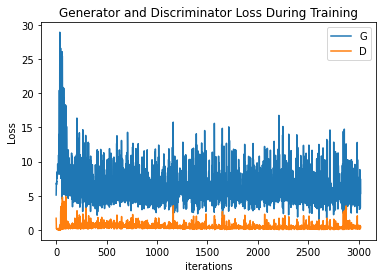

In [28]:
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

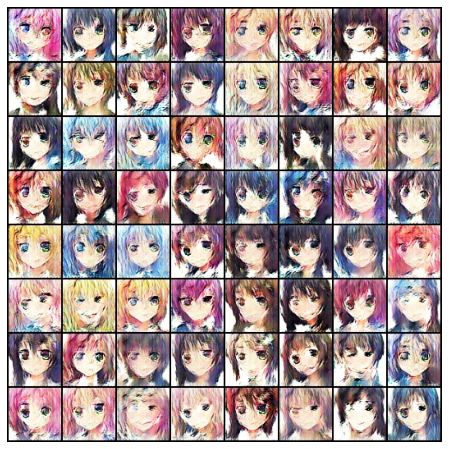

In [30]:
import matplotlib.animation as animation
from IPython.display import HTML

#%%capture
fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())